# Genetic Algorithm for Smart Charging and Discharging of EVs

This is an attempt to model the smart charging and discharging of EVs using Genetic Algorithm. The dataset used is a 96-point load data curve. The input parameters are:

1.   Duration
2.   Arrival Time
3.   Arrival SOC



In [34]:
import csv
import matplotlib.pyplot as plt
import random

## Vehicle Distribubtion
Data was collected and sampled from NHTS Survey

48
85


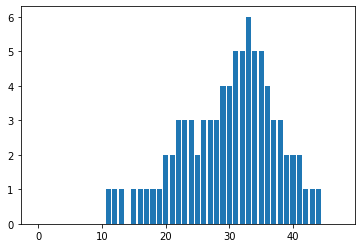

In [35]:
vehnum=[]
with open('./VPMARRIVAL1MIN.csv','r') as file:
    reader=csv.reader(file)
    i=0
    for row in reader:
        if i !=0 and i%2==0:
            vehnum.append(int(int(row[6])/1000))
        i+=1
print(len(vehnum))
# vehnum.sort()
vtot=0
for v in vehnum:
  vtot+=v
# print(vehnum[0],vehnum[95])
print(vtot)
plt.bar(range(len(vehnum)),vehnum)
plt.show()

## Genetic Algorithm

1. Initialization
2. Fitness Calculation
3. Parent Selection
4. Crossover
5. Mutation

Steps 2 through 5 are looped for a fixed number of times.


## Helper Function

In [36]:
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

Initialize Duration

In [37]:
dur=[random.randint(8,12) for x in range(vtot)]
len(dur)

85

## Initialize Population and Environment (Random shuffling of (-1,1))

In [38]:
#initialize population
from numpy import random
pop=500

cars=[[clamp(random.normal(0,1.8),-7.2,7.4)/7.4 for i in range(vtot*96)]for x in range(pop)]
dur=[random.randint(8,12)*4 for x in range(vtot)]
start=[i for i in range(48) for v in range(vehnum[i])]
end=[start[i]+dur[i] for i in range(vtot)]

soc=[0.0 for x in range(vtot*96) ]

#initialize soc
for j in range(vtot):
    soc[96*j+start[j]]=1
ogsoc=soc

#initialize battery(kwh)
ebattery=[round(soc[96*x+start[x]]*39,2) for x in range(vtot)]
ogebattery=ebattery

t=0
arrival=vehnum+[0 for i in range(48)]
freq={}
for i in end:
  if i in freq:
    freq[i]+=1
  else:
    freq[i]=1
depart=[0 for i in range(96)]
for i in range(96):
  if i in freq:
    depart[i]=freq[i]

vehpresent=[0 for i in range(96)]
vehpresent[0]=arrival[0]-depart[0]

for i in range(1,96):
  vehpresent[i]=vehpresent[i-1]+arrival[i]-depart[i]


## Load Curve

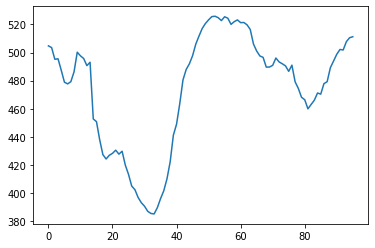

In [39]:
global P_load
P_load=[]
with open('./loadcurve.csv','r') as file:
    reader=csv.reader(file)
    i=0
    for row in reader:
        if i !=0:
            P_load.append(float(row[4]))
        i+=1

plt.plot(P_load)


## Fitness Score Calculation

In [40]:

import numpy as np

def fitness():
  global cars, P_load,fit_value,soc_value,best_fitness,pev
  best_fitness=-100000
  pev=7.4
  fit_value=[]
  soc_value=[]
  for i in range(0,pop):
    obj_fun=0
    P_econload=485
    reward=0
    soc=ogsoc
    ebattery=ogebattery
    for t in range(0,96):
        sum_pev=0
        for j in range(0,vtot):
            if start[j]<t<=end[j]:
              val=ebattery[j]+cars[i][t*vtot+j]*pev/4
              if round(val,2)>=0.8*39 and round(val,2)<39:
                ebattery[j]=round(val,2)
                sum_pev+=cars[i][t*vtot+j]*pev
                soc[96*j+t]=round((ebattery[j])/39,2)
          
            elif t==end[j]:
         
              if 0.9<=soc[96*j+end[j]]<=1:
                reward+=0.9
              elif 0.7<=soc[96*j+end[j]]<0.9:
                reward+=0.5
              elif 0.5<soc[96*j+end[j]]<0.7:
                reward+=0.1
              
            elif t>end[j]:
              soc[96*j+t]=soc[96*j+end[j]]

        obj_fun+=abs(P_load[t]-P_econload+sum_pev)
      
    fitness_score=10000/abs(obj_fun+1e-8)
    fitness_score=fitness_score+reward/100
    fit_value.append(fitness_score)
    soc_value.append(soc)

## Parent Selection 

In [41]:
#selecting parents....

def selectparent():
    global fit_value,parents,best_soc,best_fitness,max_fitness_idx,best_car
    parents =[[0.0 for i in range(vtot*96)]for j in range(2*pop)]
    best_soc=[0.0 for i in range(vtot*96)]
    max_fitness_idx= np.argmax(fit_value)
    best_fitness=fit_value[max_fitness_idx]
    best_soc=soc_value[max_fitness_idx]
    best_car=cars[max_fitness_idx]
    
    tot_fit=sum(fit_value)
    probs=[i/tot_fit for i in fit_value]
    probs = sorted([(i, f/tot_fit) for i, f in enumerate(fit_value)], key=lambda p: p[1], reverse=True)
    
    for i in range(2*pop):
        x=random.uniform(0,1)
        j=0
        while(x>=probs[j][1]):
           x-=probs[j][1]
           j+=1
        parents[i]=cars[probs[j-1][0]]

## Crossover

In [42]:
from operator import add,sub
def crossover():
     global parents,offspring 
     offspring = [[0 for i in range(vtot*96)]for j in range(pop)]
     # The point at which crossover takes place between two parents. Usually, it is at the center.
 
     for k in range(pop):
         # Index of the first parent to mate.

         parent1_idx = 2*k
         # Index of the second parent to mate.
         parent2_idx = 2*k+1
         crossover_point = random.randint(0,vtot)
         for i in range(96):
         # The new offspring will have its first half of its genes taken from the first parent.
          offspring[k][i*vtot:(i*vtot+crossover_point)] = parents[parent1_idx][i*vtot:(i*vtot+crossover_point)]
         # The new offspring will have its second half of its genes taken from the second parent.
          offspring[k][(i*vtot+crossover_point):(i*vtot+vtot)] = parents[parent2_idx][(i*vtot+crossover_point):(i*vtot+vtot)]
    

## Mutation

In [43]:
def mutation():
    global offspring
    for i,off in enumerate(offspring) :
        # The random value to be added to the gene.
          mut_val=0.01
          for j,g in enumerate(off):
            if random.uniform(0,1)<mut_val:
         
                offspring[i][j] = clamp(random.normal(0,1.8),-7.2,7.4)/7.4
    return offspring

## Main Loop

In [44]:
global parents,best,offspring
new_pop=[[0 for i in range(vtot*96)]for j in range(pop)]
best=[]
count=0
for i in range(0,10):
    if count>=10:
      break
    if len(best)>=2 and abs(best[i-2]-best[i-1])<0.5:
      count+=1
    elif len(best)>=2 and  abs(best[i-2]-best[i-1])>=0.5:
      count=0
      
    fitness()
    selectparent() 
    crossover()
    offspring_mutation=mutation()
    new_pop = offspring_mutation
    cars=new_pop
    print("best",i,":",best_fitness)
    best.append(best_fitness)

best 0 : 3.3631237090146486
best 1 : 3.4214156061854735
best 2 : 3.39435735141586
best 3 : 3.4194221589277407
best 4 : 3.403328798511775
best 5 : 3.4144738056957893
best 6 : 3.4451003214380695
best 7 : 3.419291532269117
best 8 : 3.430641450775891
best 9 : 3.426445791623093


In [45]:
len(best_soc)/85

96.0

<function matplotlib.pyplot.show(close=None, block=None)>

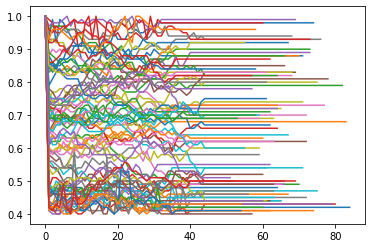

In [49]:
# time_arr=[i for i in range(96)]
for j in range(vtot):
    plt.plot(best_soc[j*96+start[j]:j*96+96])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

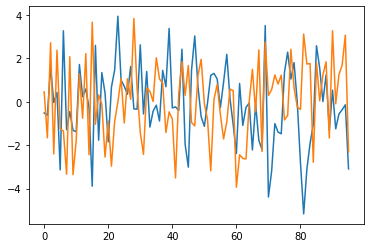

In [47]:
for i in range(vtot):
    for j in range(96):
        cars[max_fitness_idx][i*96+j]=cars[max_fitness_idx][i*96+j]*7.4
for j in range(2):
    plt.plot(cars[max_fitness_idx][j*96:j*96+96])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

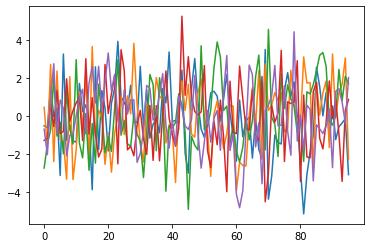

In [48]:
for j in range(5):
    plt.plot(cars[max_fitness_idx][j*96:j*96+96])
plt.show